In [5]:
# Importing the required packages
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
# Separating the data into labels and features
labels, data = data['emotion'], data.drop(['emotion','Usage'], axis=1)
data.head()

,pixels
0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,151 150 147 155 148 133 111 140 170 174 182 15...
2,231 212 156 164 174 138 161 173 182 200 106 38...
3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


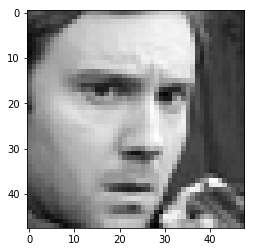

In [23]:
# Taking in the pixels of image i.e the features as a numpy array
pixel_data = data.values
pixel_data = pixel_data.astype(str)
pixel_data = np.core.defchararray.rsplit(pixel_data, sep=None, maxsplit=None)

# Visualizing the images using matplotlib
first_row = np.asarray((pixel_data)[0][0]).astype('float32')
b = first_row.reshape(48,48)
plt.imshow(b,cmap='gray')

In [9]:
# Now let's set aside the image data and process the labels. Since labels are categorical variables we can one-hot-encode them
encoded_labels = pd.get_dummies(labels)
encoded_labels = encoded_labels.as_matrix()
encoded_labels.shape

(35887, 7)

In [10]:
# Defining tensors for inputs and labels 

# Placeholder tensor for inputs. In this case, input is a 48x48 image.
input_image_data = tf.placeholder(tf.float32,shape=[None,48,48,1])

# Placeholder for labels 
label_data = tf.placeholder(tf.float32, shape=[None,7])

keep_prob = tf.placeholder(tf.float32,shape=None)

In [11]:
# Now let's start off by building the network
def build_cnn(inputs, labels):
    
    # Input layer of conv-net
    input_layer = input_image_data
    
    # First convolutional layer
    neural_net = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    # First pooling layer
    neural_net =  tf.layers.max_pooling2d(inputs=neural_net, pool_size=[2, 2], strides=2)
    
    # Second convolutional layer 
    neural_net = tf.layers.conv2d(
      inputs=neural_net,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    # Second pooling layer
    neural_net = tf.layers.max_pooling2d(inputs=neural_net, pool_size=[2,2], strides=2)
    
    # Flattening layer
    neural_net = tf.reshape(neural_net, [-1, 7 * 7 * 64])
    
    # Two stacked Fully connected layers
    neural_net = tf.layers.dense(inputs=neural_net, units=2304, activation=tf.nn.relu)
    neural_net = tf.layers.dropout(inputs=neural_net, rate=0.4)
    
    neural_net = tf.layers.dense(inputs=neural_net, units=2304, activation=tf.nn.relu)
    neural_net = tf.layers.dropout(inputs=neural_net, rate=0.4)
    
    # Output Layer
    logits = tf.layers.dense(inputs=neural_net, units=7)
    
    return logits 

In [12]:
# Calling the build_cnn function 
cnn_built = build_cnn(input_image_data, label_data)
cnn_built = tf.identity(cnn_built, name='cnn')

# Loss and optimizer 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=cnn_built, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

ValueError: Argument must be a dense tensor: 0        0
1        0
2        2
3        4
4        6
5        2
6        4
7        3
8        3
9        2
10       0
11       6
12       6
13       6
14       3
15       5
16       3
17       2
18       6
19       4
20       4
21       2
22       0
23       0
24       3
25       3
26       5
27       0
28       3
29       5
        ..
35857    5
35858    4
35859    4
35860    3
35861    6
35862    2
35863    5
35864    4
35865    3
35866    6
35867    3
35868    2
35869    3
35870    2
35871    6
35872    5
35873    4
35874    5
35875    5
35876    6
35877    6
35878    3
35879    2
35880    2
35881    0
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, dtype: int64 - got shape [35887], but wanted [].

In [ ]:
# Two functions to train the network and print stats 
def train_network(session, optimizer, keep_probability, feature_batch, label_batch):
    
    # Optimizing the neural net
    session.run(optimizer, feed_dict={x:feature_batch,y:label_batch, keep_prob:keep_probability})
    pass

def print_stats(session, feature_batch, label_batch, cost, accuracy):
    
    # Calculating loss and validation accuracy
    loss = sess.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    print("loss", loss, "valid_acc", valid_acc)
    pass    

In [ ]:
# Defining the hyperparameters
epochs = 30
batch_size = 128
keep_prob = 0.5

In [ ]:
# Finally let's get training 
print("Training on the data")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        train_network(session,optimizer, keep_probability, feature_batch, label_batch)
    
    print('Epoch {:>2}:  '.format(epoch + 1), end='')
    print_stats(sess, batch_features, batch_labels, cost, accuracy)